# Sentimental Analysis

## 1) Introduction 

The stock market is a complex space where stock prices is influenced by many factors. The common factors include economic conditions, financial statement released by publicly traded companies, geopolitical events and public sentiments. 

In this segment, we would like to focus on harnessing public sentiments, more specifically twitter sentiments, to help us predict the direction of AAPL closing stock price. 

We will be using data on historical stock price and twitter tweets over the same time period. This will provide us with sufficient information to carry out textual sentimental analysis. Thereafter, we will be using machine learning models to help determine whether AAPL closing stock price will go up or down the next trading day.

### Overview 

* Data Preprocessing
    - We will first remove any unnecessary data from our dataset that can potentially create noise and affect our results. In addition, we will also create a new categorical column reflecting whether AAPL closing price went up or down from the previous day. We will be concatenating all the tweets of the same day to a single row so as to achieve faster learning.
    - Next, we will be applying our sentimental analysis model on our dataset to determine its corresponding sentiment scores. 
* Methodology and Experiements
    - We will thereafter use these sentiment scores to train and test our machine learning models
    - We will gather the corresponding precision, recall and F1 scores of each different model so as to effectively compare which model is best for predicting movement of AAPL closing stock price
* Conclusion
    - Lastly, we will summarize our findings in this project and determine any limitations and possible improvements we could make to our model.

In [57]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# 2) Data Preprocessing
We will be using AAPL stock prices and tweets related to AAPL from 2015-01-01 to 2019-12-31. The description of the tweet data are as follows:

- tweet_id = unique id for each tweet
- writer = username of the user
- post_date = date when tweet was tweeted
- body = the body of the tweet
- comment_num = number of comments
- retweet_num = number of retweets
- like_num = number of likes

Note: There is no stock split during this period so there is no need to change the price during data cleaning

## 2a) Data Cleaning 

### Get tweet and stock data 

In [58]:
tweet = pd.read_csv("Tweet.csv")
display(tweet)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


In [4]:
aaplprice = pd.read_csv("AAPL.csv")
display(aaplprice)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565701,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873642,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875896,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210682,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140911,237458000
...,...,...,...,...,...,...,...
1252,2019-12-23,70.132500,71.062500,70.092499,71.000000,69.451057,98572000
1253,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517082,48478800
1254,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200
1255,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869423,146266000


### Removing unwanted companies
The tweet dataset shows the tweets that mentions the top NASDAQ companies. Lets remove the unwanted companies.

In [5]:
tweet = tweet[tweet['body'].str.contains('Apple|AAPL|APPLE|apple|aapl')]
display(tweet)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717957,1212159254884433921,QuantWolfLine,1577836261,Imagine calling your broker-dealer and wanting...,1,0,1
3717958,1212159275637886976,GMGRIFF_79,1577836266,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",0,0,1
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


### Cleaning the headers 
Changing the header so as to be more presentable

In [6]:
clean_tweet = pd.DataFrame(tweet[["tweet_id","writer","post_date","body","comment_num","retweet_num","like_num"]])
dict = {'tweet_id' : 'Tweet ID',
        'writer' : 'Writer',
        'post_date' : 'Date',
        'body' : 'Tweet',
        'comment_num' : 'Comments',
        'retweet_num' : 'Retweets',
        'like_num' : 'Likes'
       }
tweet1 = clean_tweet.rename(columns=dict)
tweet1.reset_index(inplace=True,drop=True)
tweet1.head()

,Tweet ID,Writer,Date,Tweet,Comments,Retweets,Likes
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
3,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
4,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


### Cleaning up date  
We further clean the dataset by converting UNIX time to GMT

In [7]:
#Converting unix date to datetime, as well as removing time posted->only show date posted
#Converting GMT+3 to GMT
import datetime
import pytz
tweet1['Date'] = tweet1['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, pytz.timezone('Etc/GMT+3')).astimezone(pytz.timezone('Etc/GMT')))
tweet1['Date'] = tweet1['Date'].dt.date
tweet1 = tweet1.sort_values('Date', ascending=True)
display(tweet1)

,Tweet ID,Writer,Date,Tweet,Comments,Retweets,Likes
0,550441509175443456,VisualStockRSRC,2015-01-01,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
206,550736241738526720,TweakTown,2015-01-01,Apple faces lawsuit over massive storage space...,0,0,2
205,550732338670227457,MacHashNews,2015-01-01,"Today's apps gone free: Decide Now, OftenType,...",0,1,3
204,550731345614602240,TalkMarkets,2015-01-01,Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...,0,0,1
203,550730566656876548,johnmknox,2015-01-01,Availability & price are a huge problem plagui...,0,0,1
...,...,...,...,...,...,...,...
1496446,1212019899020611586,HottestStockNow,2019-12-31,"Thinking about buying stock in $AAPL, $BBY, $C...",0,0,0
1496447,1212020035910275072,RyanSTTrader,2019-12-31,$AAPL Unreal,0,0,1
1496448,1212020218878296066,seattlehikertoo,2019-12-31,$AAPL march to more nath. 5G coming and everyo...,0,0,0
1496450,1212020375711887362,IchimokuD,2019-12-31,If it is true that everyone already owns Apple...,0,0,0


### Further cleaning 
Tweets usually contains the following:

    1. User Tags (Starts with @)
    
    2. Website Links (Starts with http)
        
To allow for better modelling, we will replace these with generic terms so as to not affect our sentiment score

In [9]:
#Replacing user tags and website links to generic terms

# Define a function to clean the text
def clean_text(text):
    words = text.split()
    for i in range(len(words)):
        if words[i].startswith('@'):
            words[i] = '@user'
        elif words[i].startswith('http'):
            words[i] = 'http'
    return ' '.join(words)

# Apply the clean_text function to the 'text' column
tweet1['Tweet'] = tweet1['Tweet'].apply(clean_text)
# Display the results
display(tweet1)

,Tweet ID,Writer,Date,Tweet,Comments,Retweets,Likes
0,550441509175443456,VisualStockRSRC,2015-01-01,"lx21 made $10,008 on $AAPL -Check it out! http...",0,0,1
206,550736241738526720,TweakTown,2015-01-01,Apple faces lawsuit over massive storage space...,0,0,2
205,550732338670227457,MacHashNews,2015-01-01,"Today's apps gone free: Decide Now, OftenType,...",0,1,3
204,550731345614602240,TalkMarkets,2015-01-01,Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...,0,0,1
203,550730566656876548,johnmknox,2015-01-01,Availability & price are a huge problem plagui...,0,0,1
...,...,...,...,...,...,...,...
1496446,1212019899020611586,HottestStockNow,2019-12-31,"Thinking about buying stock in $AAPL, $BBY, $C...",0,0,0
1496447,1212020035910275072,RyanSTTrader,2019-12-31,$AAPL Unreal,0,0,1
1496448,1212020218878296066,seattlehikertoo,2019-12-31,$AAPL march to more nath. 5G coming and everyo...,0,0,0
1496450,1212020375711887362,IchimokuD,2019-12-31,If it is true that everyone already owns Apple...,0,0,0


### Creating Categorical Column

We will add a column 'Label'. A value of 1 means that closing stock price went up from the previous close and 0 means closing stock price went down from previous close

In [10]:
# Shift the 'Close' column by 1 day to get the previous day's prices
aaplprice['Prev Close'] = aaplprice['Close'].shift(1)

# Compare 'Close' with 'Prev Close' to get the labels
aaplprice['Label'] = (aaplprice['Close'] > aaplprice['Prev Close']).astype(int)

#AAPL close price before 02/01/2015 is 27.59
aaplprice.loc[0, 'Label'] = 1
aaplprice.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev Close,Label
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565701,212818400,NaN,1
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873642,257142000,27.332500,0
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875896,263188400,26.562500,1
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210682,160423600,26.565001,1
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140911,237458000,26.937500,1


In [11]:
#Change in price from open to close
aaplprice['Change'] = aaplprice['Open'] - aaplprice['Close']
aaplprice.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev Close,Label,Change
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565701,212818400,NaN,1,0.515000
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873642,257142000,27.332500,0,0.510000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875896,263188400,26.562500,1,0.069999
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210682,160423600,26.565001,1,-0.137501
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140911,237458000,26.937500,1,-0.664999


### Sentimental Analysis using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is particularly good for analysing sentiment of social media texts as it takes into account linguistic features within a social media text. VADER provides 4 normalised sentiment scores: Negative, Neutral, Positive and Compound. The positive, negative, and neutral scores (ranging from 0 to 1) represent the proportion of the text that is positive, negative, or neutral, respectively. The compound score (ranging from -1 to 1) provides an indication as overall indication of the sentiment of the text.

Given the social nature of tweets, we will be using the VADER model as it is very appropriate.


In [16]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\justi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The dataset is very massive with over 1 million rows. Running the model will take a few days to complete which is not very efficient. We will concatenate tweets of the same day together. 

To show the concatenating tweets will not affect the conclusion we can derive from the score, let us take a look at the following examples. When we concatenate 2 strings with opposing sentiment, the negative and positive values are scaled closer to 0. Concatenating 2 strings with the same sentiment will result in an unchanged sentiment value. Furthermore, given that these tweets are related to AAPL stock price, concatenating tweets will not result in too much loss in information or context

In [19]:
sia.polarity_scores("I am happy")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [20]:
sia.polarity_scores("I am sad")

{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [32]:
#Concatenating 2 strings with different sentiment 
sia.polarity_scores("I am happy I am sad")

{'neg': 0.352, 'neu': 0.227, 'pos': 0.42, 'compound': 0.1531}

In [29]:
#Concatenating 2 strings with same sentiment
sia.polarity_scores("I am happy I am happy")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.8126}

In [33]:
#Grouping tweets of the same day together
groupedtweet = tweet1.groupby('Date')['Tweet'].apply(' '.join).reset_index()
groupedtweet

,Date,Tweet
0,2015-01-01,"lx21 made $10,008 on $AAPL -Check it out! http..."
1,2015-01-02,Stock_Tracker: $AAPL Recent Headlines 5 New Ye...
2,2015-01-03,Free 5€ in account balance for first 100.000 m...
3,2015-01-04,Jake13: $AAPL Opinion Today Click here to find...
4,2015-01-05,Get $25 when you sign up http #Payoneer w/ my ...
...,...,...
1821,2019-12-27,$AAPL is starting to see Puts coming in. The 1...
1822,2019-12-28,$MTCH $DLTR $QCOM $INTC $AAPL $MSFT $SBUX $AMA...
1823,2019-12-29,Chart Patterns to Watch This Week 12-29-2019 h...
1824,2019-12-30,BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL...


In [34]:
#Retrieving polarity scores
res = {}

for i,row in tqdm(groupedtweet.iterrows(), total=len(groupedtweet)):
    text = row['Tweet']
    res[i] = sia.polarity_scores(text)

100%|██████████| 1826/1826 [24:22<00:00,  1.25it/s] 


In [36]:
# Adding polarity scores to dataframe
result = pd.DataFrame(res).T
merged_df = pd.merge(groupedtweet, result, left_index=True, right_index=True)
merged_df

,Date,Tweet,neg,neu,pos,compound
0,2015-01-01,"lx21 made $10,008 on $AAPL -Check it out! http...",0.034,0.848,0.119,0.9999
1,2015-01-02,Stock_Tracker: $AAPL Recent Headlines 5 New Ye...,0.052,0.837,0.111,1.0000
2,2015-01-03,Free 5€ in account balance for first 100.000 m...,0.025,0.821,0.154,1.0000
3,2015-01-04,Jake13: $AAPL Opinion Today Click here to find...,0.030,0.828,0.142,1.0000
4,2015-01-05,Get $25 when you sign up http #Payoneer w/ my ...,0.046,0.824,0.129,1.0000
...,...,...,...,...,...,...
1821,2019-12-27,$AAPL is starting to see Puts coming in. The 1...,0.042,0.840,0.119,1.0000
1822,2019-12-28,$MTCH $DLTR $QCOM $INTC $AAPL $MSFT $SBUX $AMA...,0.033,0.853,0.114,0.9999
1823,2019-12-29,Chart Patterns to Watch This Week 12-29-2019 h...,0.039,0.844,0.116,0.9999
1824,2019-12-30,BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL...,0.041,0.821,0.138,1.0000


## Merging stockprice and tweet dataframe

In the process of merging, we will drop the tweets that were tweeted on Saturday, Sunday and public holidays as the stock market is not open on those days.

In [40]:
# Convert the 'Date' column in the 'aaplprice' DataFrame to datetime format
aaplprice['Date'] = pd.to_datetime(aaplprice['Date'], format='%Y-%m-%d')
# Convert the 'Date' column in the 'merged_df' DataFrame to a datetime object
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [41]:
sentimentAndStockPrice = pd.merge(merged_df, aaplprice[['Date', 'Close','Label','Open','High','Low','Adj Close','Volume']], on='Date')
display(sentimentAndStockPrice)

,Date,Tweet,neg,neu,pos,compound,Close,Label,Open,High,Low,Adj Close,Volume
0,2015-01-02,Stock_Tracker: $AAPL Recent Headlines 5 New Ye...,0.052,0.837,0.111,1.0,27.332500,1,27.847500,27.860001,26.837500,24.565701,212818400
1,2015-01-05,Get $25 when you sign up http #Payoneer w/ my ...,0.046,0.824,0.129,1.0,26.562500,0,27.072500,27.162500,26.352501,23.873642,257142000
2,2015-01-06,"$AAPL: 3 open, suited signals indicate continu...",0.049,0.814,0.137,1.0,26.565001,1,26.635000,26.857500,26.157499,23.875896,263188400
3,2015-01-07,$AAPL - strategy MACD and RSI alert - LOL: How...,0.044,0.834,0.123,1.0,26.937500,1,26.799999,27.049999,26.674999,24.210682,160423600
4,2015-01-08,"$AAPL stock content, charts, analysis, & more ...",0.034,0.830,0.136,1.0,27.972500,1,27.307501,28.037500,27.174999,25.140911,237458000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2019-12-23,$AAPL high OI range is 0.00 to 0.00 for option...,0.044,0.862,0.094,1.0,71.000000,1,70.132500,71.062500,70.092499,69.451057,98572000
1253,2019-12-24,How I Modded the Silicone Tips of AirPods Pro ...,0.040,0.835,0.125,1.0,71.067497,1,71.172501,71.222504,70.730003,69.517082,48478800
1254,2019-12-26,$AAPL 60 min update $KWBT Visible Whale Count ...,0.041,0.835,0.124,1.0,72.477501,1,71.205002,72.495003,71.175003,70.896332,93121200
1255,2019-12-27,$AAPL is starting to see Puts coming in. The 1...,0.042,0.840,0.119,1.0,72.449997,0,72.779999,73.492500,72.029999,70.869423,146266000


### Final check to ensure that dataframe has no null values 

In [42]:
sentimentAndStockPrice.isnull().sum()

Date         0
Tweet        0
neg          0
neu          0
pos          0
compound     0
Close        0
Label        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64

## 2b) Exploratory Data Analysis

### Plotting variables against stock price
From the graphs, we can visually observe that when a variable such as negative or positive changes, the direction of the stock price will generally follow suit

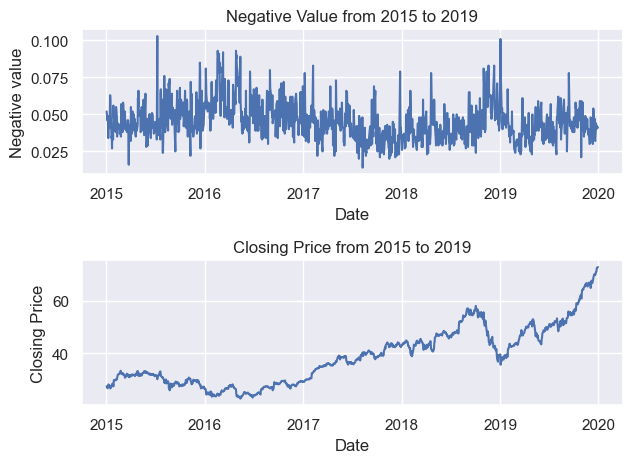

In [59]:
plt.subplot(2, 1, 1) 
plt.plot(sentimentAndStockPrice['Date'], sentimentAndStockPrice['neg'])
plt.xlabel('Date')
plt.ylabel('Negative value')
plt.title('Negative Value from 2015 to 2019')

plt.subplot(2, 1, 2) 
plt.plot(aaplprice['Date'], aaplprice['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price from 2015 to 2019')

plt.tight_layout()
plt.show()

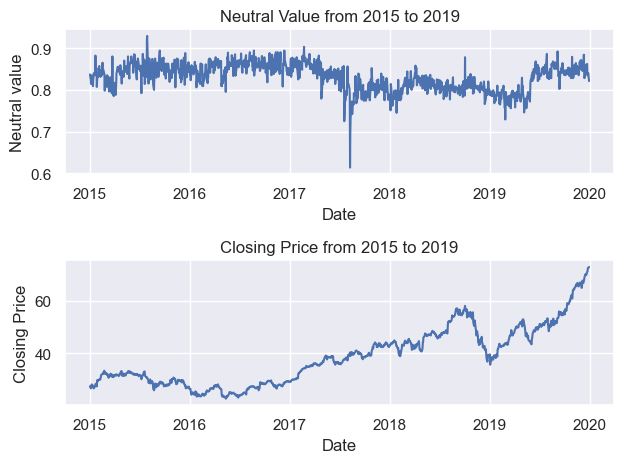

In [60]:
plt.subplot(2, 1, 1) 
plt.plot(sentimentAndStockPrice['Date'], sentimentAndStockPrice['neu'])
plt.xlabel('Date')
plt.ylabel('Neutral value')
plt.title('Neutral Value from 2015 to 2019')

plt.subplot(2, 1, 2) 
plt.plot(aaplprice['Date'], aaplprice['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price from 2015 to 2019')

plt.tight_layout()
plt.show()

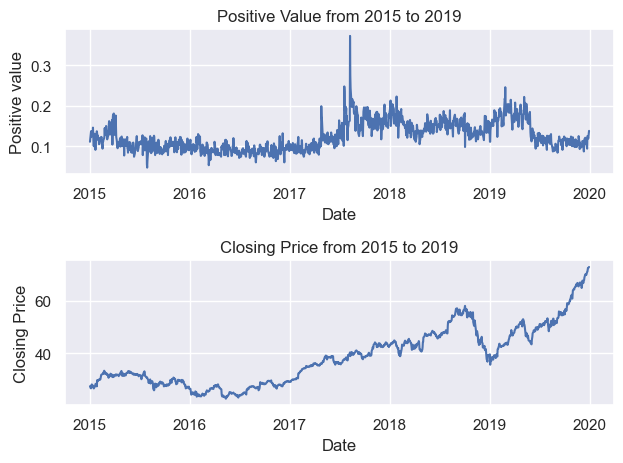

In [62]:
plt.subplot(2, 1, 1) 
plt.plot(sentimentAndStockPrice['Date'], sentimentAndStockPrice['pos'])
plt.xlabel('Date')
plt.ylabel('Positive value')
plt.title('Positive Value from 2015 to 2019')

plt.subplot(2, 1, 2) 
plt.plot(aaplprice['Date'], aaplprice['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price from 2015 to 2019')

plt.tight_layout()
plt.show()

### Visualising the distribution of sentiment values 

Text(0, 0.5, 'Frequency')

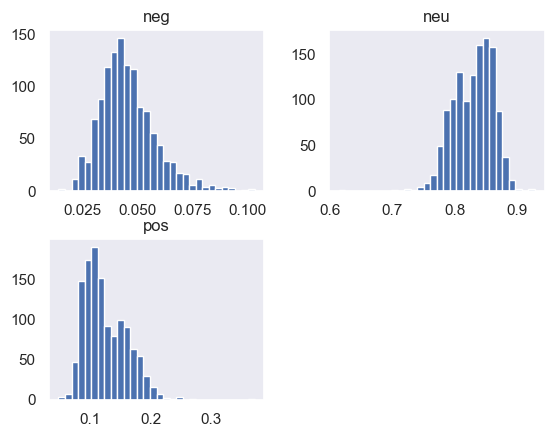

In [133]:
hist = sentimentAndStockPrice.hist(column=['neg', 'neu', 'pos'], bins=30, grid=False)

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

### Observation 1: Positive skew of sentiment values

'neg' and 'pos' variables have a positive skew. We will correct them using log transformation. This is important later on as our model depends on a normal distribution

Text(0, 0.5, 'Frequency')

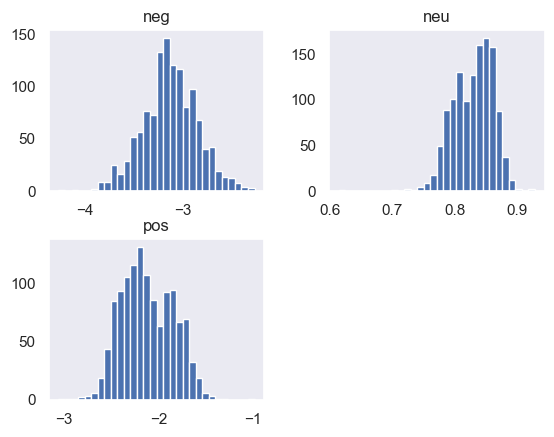

In [134]:
sentimentAndStockPrice['neg'] = np.log(sentimentAndStockPrice['neg'])
sentimentAndStockPrice['pos'] = np.log(sentimentAndStockPrice['pos'])

hist = sentimentAndStockPrice.hist(column=['neg', 'neu', 'pos'], bins=30, grid=False)

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

### Visualising correlation between sentiment values and AAPL daily close price 

In [46]:
#Printing correlation matrix
corr_matrix = sentimentAndStockPrice[['Close','neg', 'neu', 'pos']].corr()[['Close']]
corr_matrix

,Close
Close,1.000000
neg,-0.323881
neu,-0.359332
pos,0.441454


### Observation 2: Pos and neg have medium correlation with daily close price

'neg' has a correlation of -0.323881 and 'pos' has a correlation of 0.441454 against closing price. Since negative and positive have a medium correlation against AAPL daily close price, we can use these 2 variables for our model. 

We will not use neutral values as they do not display any emotions or sentiments from tweet users that can help to predict stock price

## 3) Methodology

We will use the sentiment variables, namely negative and positive values, to help predict whether or not the stock price will rise or fall. Since our sentiment values range from 0 to 1, it is not possible to predict the stock price as the stock price can reach new highs and these data is not present in our dataset (i.e. if stock price keeps going up, our sentiment variable will never exceed 1). Given this limitation, we can however still use twitter sentiment to predict whether or not AAPL stock price will rise or fall given the sentiment on that day

### Creating train test set

Given that we are handling a time series data, we will not be using any cross validation methods. Train set will be from 2015-2018, Test set will be 2019

In [48]:
#Prepare training set
date_range = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
new_df = pd.DataFrame({'date': date_range})
new_df['date'] = pd.to_datetime(new_df['date'])

train_df = pd.merge(sentimentAndStockPrice, new_df, left_on=sentimentAndStockPrice['Date'].dt.date, right_on=new_df['date'].dt.date, how='right')
train_df.dropna(inplace=True)
train_df.drop(columns=['key_0','date'], inplace=True)
train_df.head()

,Date,Tweet,neg,neu,pos,compound,Close,Label,Open,High,Low,Adj Close,Volume
1,2015-01-02,Stock_Tracker: $AAPL Recent Headlines 5 New Ye...,0.052,0.837,0.111,1.0,27.332500,1.0,27.847500,27.860001,26.837500,24.565701,212818400.0
4,2015-01-05,Get $25 when you sign up http #Payoneer w/ my ...,0.046,0.824,0.129,1.0,26.562500,0.0,27.072500,27.162500,26.352501,23.873642,257142000.0
5,2015-01-06,"$AAPL: 3 open, suited signals indicate continu...",0.049,0.814,0.137,1.0,26.565001,1.0,26.635000,26.857500,26.157499,23.875896,263188400.0
6,2015-01-07,$AAPL - strategy MACD and RSI alert - LOL: How...,0.044,0.834,0.123,1.0,26.937500,1.0,26.799999,27.049999,26.674999,24.210682,160423600.0
7,2015-01-08,"$AAPL stock content, charts, analysis, & more ...",0.034,0.830,0.136,1.0,27.972500,1.0,27.307501,28.037500,27.174999,25.140911,237458000.0


In [49]:
#Prepare test set
date_range = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')
new_df1 = pd.DataFrame({'date': date_range})
new_df1['date'] = pd.to_datetime(new_df1['date'])

test_df = pd.merge(sentimentAndStockPrice, new_df1, left_on=sentimentAndStockPrice['Date'].dt.date, right_on=new_df1['date'].dt.date, how='right')
test_df.dropna(inplace=True)
test_df.drop(columns=['key_0','date'], inplace=True)
test_df.head()

,Date,Tweet,neg,neu,pos,compound,Close,Label,Open,High,Low,Adj Close,Volume
1,2019-01-02,$AAPL collapsing LOL Tim Cook’s vision was to ...,0.101,0.788,0.111,1.0,39.480000,1.0,38.722500,39.712502,38.557499,38.047039,148158800.0
2,2019-01-03,"Yeah, $AAPL had been ""Holding"" that Sales Info...",0.099,0.790,0.111,1.0,35.547501,0.0,35.994999,36.430000,35.500000,34.257286,365248800.0
3,2019-01-04,Yep. I did a #podcast about why $AAPL stock ta...,0.074,0.787,0.139,1.0,37.064999,1.0,36.132500,37.137501,35.950001,35.719707,234428400.0
6,2019-01-07,+500 $INDU and $AAPL goes green. Book it. Here...,0.051,0.791,0.158,1.0,36.982498,0.0,37.174999,37.207500,36.474998,35.640190,219111200.0
7,2019-01-08,that's what FATUOUS @user gov shutdown brings ...,0.054,0.796,0.150,1.0,37.687500,1.0,37.389999,37.955002,37.130001,36.319607,164101200.0


In [68]:
# Split into train test set
X_train = np.array(train_df[['neg','pos']])
Y_train = train_df['Label'].values
X_test = np.array(test_df[['neg','pos']])
Y_test = test_df['Label'].values

### Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) is a supervised machine learning algorithm that is used for classification tasks. LDA helps to find a linear combination of features that can best separate 2 or more classes of data. 

In LDA, the input data consists of a set of labeled samples, where each sample has a set of features or attributes. The algorithm seeks to find a projection of the data onto a lower-dimensional space, such that the samples in each class are well-separated from each other and as far apart as possible. This lower-dimensional space is called the discriminant space.

LDA would then be used to find a projection of the data onto a lower-dimensional space, such that the samples in each class are well-separated from each other and as far apart as possible. The resulting projection can be used to classify new samples by assigning them to the class that is closest to their projected value. 

In the context of predicting AAPL stock price direction, LDA takes in AAPL stock price as well as the negative and positive sentiment values to help derive whether to buy or sell a stock. This information can be particularly useful for day traders whose objective is to enter and exit a trade within a short period of time.

In [47]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [69]:
model = LinearDiscriminantAnalysis().fit(X_train,Y_train)

In [74]:
predictions = model.predict(X_test)
predictions

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1.

In [75]:
Y_test

array([1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0.

In [77]:
#Show the model metrics
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.53      0.27      0.36       106
         1.0       0.61      0.82      0.70       145

    accuracy                           0.59       251
   macro avg       0.57      0.55      0.53       251
weighted avg       0.57      0.59      0.56       251



### LDA Results

We have achieved the following with LDA:

- Overall Accuracy of 0.59
- For predicting close price dropping (class 0.0):
    - Precision of 0.53
    - Recall of 0.27
    - f1-score of 0.36
- For predicting close price increasing (class 1.0):
    - Precision of 0.61
    - Recall of 0.82
    - f1-score of 0.70

We can conclude the following from using LDA:

- Precision: Only 53% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 61% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 27% of the negative samples are correctly categorised as negative. 82% (A high percentage) of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.70) than predicting decrease(0.36) in AAPL close price. Overall, LDA is better used to predict whether AAPL close price goes up than predicting whether it goes down

## Further experimenting 

Given that LDA is rather inaccurate in predicting the fall in closing price, let us bring in a few more classification models that can help to cover this gap. We will be using the same metrics as above to compare our model effectivness. Namely:
1. Accuracy
2. Precision
3. Recall
4. f1-score


We will compare LDA with 2 other classification models:
1. Logistic Regression
2. Random Forest

## Logistic Regression 

Logistic regression is useful in predicting binary outcomes which can be useful in our case of predicting stock price movement.

Logistic regression relies heavily in linearity between the independent variables and the log-odds of the dependent variable.

Logistic regression can be useful in this scenario as it is a relatively simple and interpretable model that can provide insights into the factors that are driving stock price movements. Additionally, logistic regression can be used to estimate the probability of a particular event occurring, such as the probability of a stock price going up or down, which can be useful for making informed investment decisions.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [99]:
model2 = LogisticRegression().fit(X_train,Y_train)

# Predict on the test set
LR_pred = model2.predict(X_test)

In [100]:
LR_pred

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [94]:
Y_test

array([1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0.

In [95]:
print(classification_report(Y_test,LR_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.01      0.02       106
         1.0       0.58      0.99      0.73       145

    accuracy                           0.58       251
   macro avg       0.54      0.50      0.37       251
weighted avg       0.55      0.58      0.43       251



### Logistic Regression Results
We have achieved the following with Logistic Regression:

- Overall Accuracy of 0.58
- For predicting close price dropping (class 0.0):
    - Precision of 0.50
    - Recall of 0.01
    - f1-score of 0.02
- For predicting close price increasing (class 1.0):
    - Precision of 0.58
    - Recall of 0.99
    - f1-score of 0.73

We can conclude the following from using Logistic Regression:

- Precision: Only 50% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 58% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 1% of the negative samples are correctly categorised as negative. 99% (A high percentage) of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.73) than predicting decrease(0.02) in AAPL close price.

### Random Forest Classifier

Random forest classifier is well suited in predicting stock price movement because it can handle complex and non-linear relationship between the independent variable (which in this case is sentiment values) and target variable (movement of stock closing price)

Random forest works by creating multiple decision trees and combining their predictions to generate a final prediction. Each decision tree is trained on a random subset of the data, and each split in the tree is based on a randomly selected subset of the features. This helps to reduce overfitting and improve the model's generalization performance.

Random forest classifier can be used because it can handle numerous features which in this case is positive and negative sentiment values.

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
model3 = RandomForestClassifier().fit(X_train,Y_train)

# Predict on the test set
RFC_pred = model3.predict(X_test)

In [101]:
RFC_pred

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1.

In [102]:
Y_test

array([1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0.

In [103]:
print(classification_report(Y_test,RFC_pred))

              precision    recall  f1-score   support

         0.0       0.48      0.45      0.46       106
         1.0       0.61      0.63      0.62       145

    accuracy                           0.56       251
   macro avg       0.54      0.54      0.54       251
weighted avg       0.56      0.56      0.56       251



### Random Forest Classifier Results
We have achieved the following with Logistic Regression:

- Overall Accuracy of 0.56
- For predicting close price dropping (class 0.0):
    - Precision of 0.48
    - Recall of 0.45
    - f1-score of 0.46
- For predicting close price increasing (class 1.0):
    - Precision of 0.61
    - Recall of 0.63
    - f1-score of 0.62

We can conclude the following from using Random Forest Classifier:

- Precision: Only 48% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 61% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 45% of the negative samples are correctly categorised as negative. 63% of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.62) than predicting decrease(0.46) in AAPL close price.

## Comparing all 3 models

We will a barplot to visualise how each model fares 

## Comparing class 0 (Predicting fall in close price)

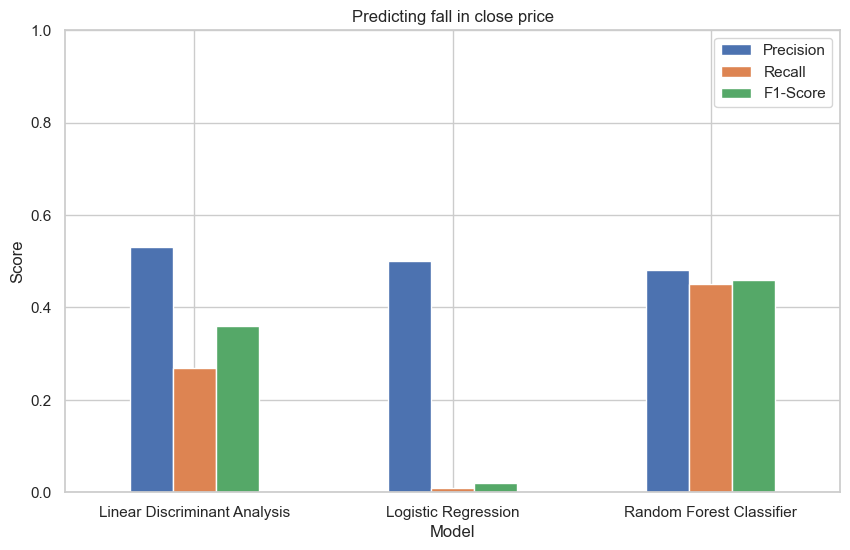

In [115]:
# Define data as a dictionary of models and their classification report
data = {'Linear Discriminant Analysis': [0.53,0.27,0.36],
        'Logistic Regression': [0.50, 0.01, 0.02],
        'Random Forest Classifier': [0.48, 0.45, 0.46]}
# Convert data to a DataFrame and transpose it
df = pd.DataFrame(data).T

# Plot the bar plot
sb.set(style="whitegrid")
ax = df.plot(kind='bar', rot=0, figsize=(10, 6))
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
plt.title('Predicting fall in close price')
plt.legend(labels=['Precision', 'Recall', 'F1-Score'])
plt.show()

## Comparing class 1 (Predicting rise in close price)

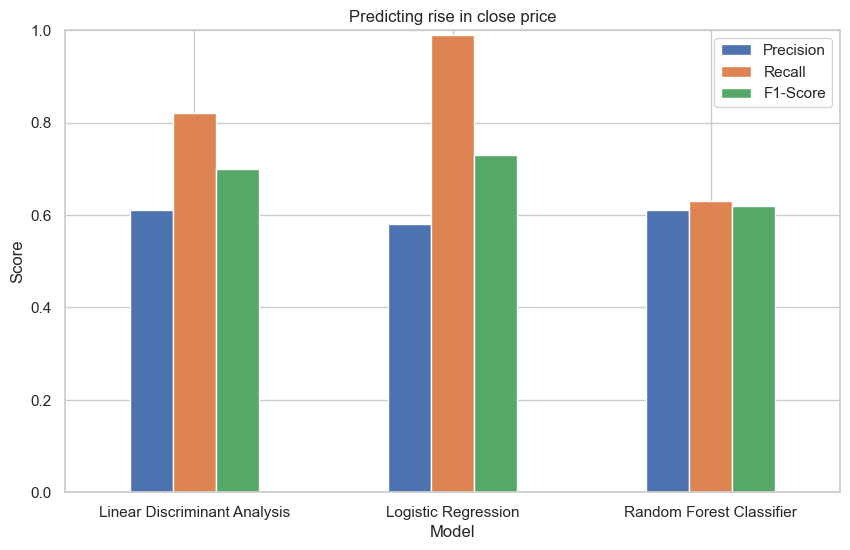

In [116]:
# Define data as a dictionary of models and their classification report
data = {'Linear Discriminant Analysis': [0.61,0.82,0.70],
        'Logistic Regression': [0.58,0.99,0.73],
        'Random Forest Classifier': [0.61,0.63,0.62]}
# Convert data to a DataFrame and transpose it
df = pd.DataFrame(data).T

# Plot the bar plot
sb.set(style="whitegrid")
ax = df.plot(kind='bar', rot=0, figsize=(10, 6))
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
plt.title('Predicting rise in close price')
plt.legend(labels=['Precision', 'Recall', 'F1-Score'])
plt.show()

### Comparing all 3 models, we conclude the following:

Ranking based on overall performance:

1. Random Forest Classifier
2. Linear Discriminant Analysis
3. Logistic Regression Model

Starting off, random forest classifier proved to be a relatively reliable model with a 56% accuracy. All things considered, it is the preferable model to be used for prediction.

Linear Discriminant Analysis came up with a 59% accuracy. However, it is important to note that it fares poorly in predicting a fall in stock close price (f1-score of 0.36)

Lastly, Logistic regression fared the worst as most of its prediction predicted a rise in close price. 

# 5) Conclusion

We can conclude that there is a medium correlation between twitter sentiments and the AAPL closing price movement. As such, there is a premise to carry out machine learning to use twitter sentiments to predict AAPL closing price movement. In the context of social media sentiment, the models proved to have a high percentage accuracy given the noise and complexity of the data we are handling with. Even though we did as much textual cleaning as possible, it is difficult to perfectly clean our dataset of over 1 million tweets. In addition, given the highly speculative nature of people, what people say on twitter may not effectively translate into a accurate stock close price movement. 

Given the competitive trading space and high stakes nature that involves the use of people's hard earned money, we cannot completely rely on sentimental analysis to make stock price movement predictions. Rather, we can use it hand in hand with other indicators such as economic indicators and stock technical indicators to help come up with an educated prediction 

# 6) Limitations and Possible Improvements 

-Limitation: Relatively unreliable textual source 
Twitter is not representative of the entire population. The demographics that uses twitter are mainly millenials whereas the people involved in the stock market are of a wide range of age. In addition, tweets can contain sarcasm, which is difficult for current sentiment models to read and predict. 

-Improvement : We can incorporate financial news articles into our sentiment analysis. New articles tend to be less biased and contain less noise.
